Setting up local paths

In [4]:
import os
base_path = r"D:\Projects\PYTHON\Pneumonia\Dataset"
train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "val")
test_path = os.path.join(base_path, "test")

print("Train path exists:", os.path.exists(train_path))
print("Sample Normal images in train:", os.listdir(os.path.join(train_path, "NORMAL"))[:5])


Train path exists: True
Sample Normal images in train: ['IM-0115-0001.jpeg', 'IM-0117-0001.jpeg', 'IM-0119-0001.jpeg', 'IM-0122-0001.jpeg', 'IM-0125-0001.jpeg']


 Import Libraries & Preprocess Data

In [5]:
# Step 2: Data Preprocessing
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset
train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_data = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_data = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Build CNN Model

In [6]:
# Step 3: Build Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\ADITYA\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Train The Model

In [8]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)


Num GPUs Available:  0
TensorFlow version: 2.18.0


In [7]:
# Step 4: Model Training with EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',        # stop when validation loss stops improving
    patience=20,                # wait 5 epochs before stopping
    restore_best_weights=True  # restore the best weights after stopping
)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,               # maximum epochs
    callbacks=[early_stop]    # use EarlyStopping
)


c:\Users\ADITYA\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
 20/163 ━━━━━━━━━━━━━━━━━━━━ 2:20 981ms/step - accuracy: 0.5566 - loss: 1.2120

KeyboardInterrupt: 

Evaluate Model

In [25]:
# Step 5: Evaluate Model
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 560ms/step - accuracy: 0.8686 - loss: 0.5077
Test Accuracy: 83.65%


Visualize accuracy and loss

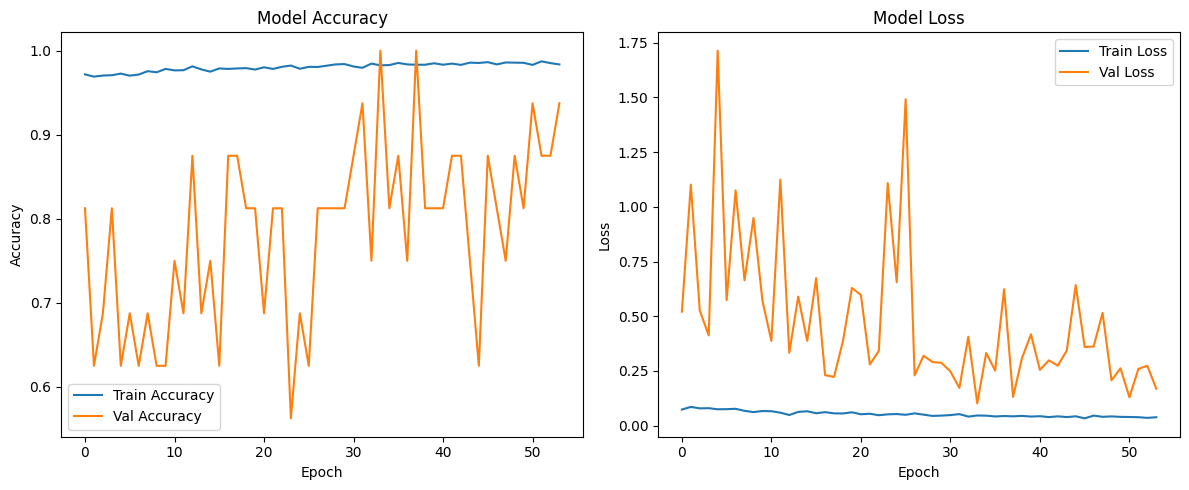

In [26]:
# Step 6: Plot Accuracy and Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Make prediction on a single image

In [30]:
# Step 7: Inference on a Single Image
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    label = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
    print(f"Prediction: {label} (Confidence: {prediction:.2f})")

# Example:
predict_image(r"D:\Projects\PYTHON\Pneumonia\Dataset\val\PNEUMONIA\person1949_bacteria_4880.jpeg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction: PNEUMONIA (Confidence: 1.00)


Save and Load model

In [31]:
# Step 8: Save model in .keras format
model.save("xray_model.keras")
print("Model saved in .keras format!")

# Load model
from tensorflow.keras.models import load_model
loaded_model = load_model("xray_model.keras")
print("Model loaded successfully!")


Model saved in .keras format!
Model loaded successfully!
